##TECH THUGS
This module has pretrained model.
Which will be used for text extraction


In [1]:
!pip install keras-tqdm
import numpy as np
import cv2
import os
import pandas as pd
import string
import matplotlib.pyplot as plt

from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras_tqdm import TQDMNotebookCallback

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf

#ignore warnings in the output
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from tensorflow.python.client import device_lib

# Check all available devices if GPU is available
print(device_lib.list_local_devices())
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
tf.config.experimental.list_physical_devices('GPU')

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12421457174453112892
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4790967515139170020
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10863998912942570262
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14640891840
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9678866808845701216
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
max_label_len = 0

char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz" 

# string.ascii_letters + string.digits (Chars & Digits)
# or 
# "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

print(char_list, len(char_list))

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, chara in enumerate(txt):
        dig_lst.append(char_list.index(chara))
        
    return dig_lst

!"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz 78


In [5]:
def process_image(img):
    """
    Converts image to shape (32, 128, 1) & normalize
    """
    w, h = img.shape
    
#     _, img = cv2.threshold(img, 
#                            128, 
#                            255, 
#                            cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # Aspect Ratio Calculation
    new_w = 32
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape
    
    img = img.astype('float32')
    
    # Converts each to (32, 128, 1)
    if w < 32:
        add_zeros = np.full((32-w, h), 255)
        img = np.concatenate((img, add_zeros))
        w, h = img.shape
    
    if h < 128:
        add_zeros = np.full((w, 128-h), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h = img.shape
        
    if h > 128 or w > 32:
        dim = (128,32)
        img = cv2.resize(img, dim)
    
   # img = cv2.subtract(255, img)
    
    img = np.expand_dims(img, axis=2)
    
    # Normalize 
    img = img / 255
    
    return img

In [6]:
# input with shape of height=32 and width=128 
inputs = Input(shape=(32,128,1))
 
# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
 
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 
# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(blstm_1)
 
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

Upload the Weights file (.hdf5 file ) to drive.
Paste the path here.

In [8]:
act_model.load_weights('/content/drive/My Drive/TECH THUGS- Smart Document/sgdo-10000r-30e-7850t-876v.hdf5')

Upload the image for predicting the word. Put the correct path

In [10]:
import os

onlyfiles = next(os.walk('/content/drive/My Drive/to predict words'))[2] #dir is your directory path as string
p = len(onlyfiles)
print(p)

0


In [ ]:

!pip install pyspellchecker

In [ ]:
from spellchecker import SpellChecker

spell = SpellChecker()

In [11]:
def pred(img):
  pxmin = np.min(img)
  pxmax = np.max(img)
  imgContrast = (img - pxmin) / (pxmax - pxmin) * 255
  wi=''
  worda=[]
# increase line width
  kernel = np.ones((3, 3), np.uint8)
  imgMorph = cv2.erode(imgContrast, kernel, iterations = 1)
  p=process_image(imgMorph)
  p=p.reshape((1,32,128,1))
  prediction = act_model.predict(p)
  out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])
  for x in out:
   # print("original_text =  ", valid_original_text[i])
    #print("predicted text = ", end = '')
    for p in x:  
        if int(p) != -1:
           worda.append(char_list[int(p)])   
    wi=wi.join(worda)   
  return wi    

In [12]:

imgs=[]


In [13]:
import glob
import matplotlib.image as mpimg
print_words=[]

pre_proc=[]


import os
arr = os.listdir('/content/drive/My Drive/to predict words')
arr=sorted(arr)



for i in arr:
  img = cv2.imread('/content/drive/My Drive/to predict words/{}'.format(i), cv2.COLOR_BGR2GRAY)
  imgs.append(img)
  print_words.append(pred(img))
  image = mpimg.imread('/content/drive/My Drive/to predict words/{}'.format(i))



   

In [14]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

PREDICTED TEST 




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


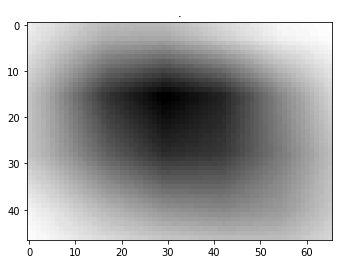

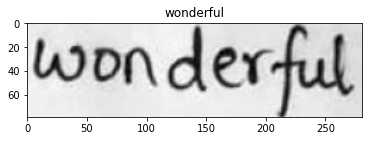

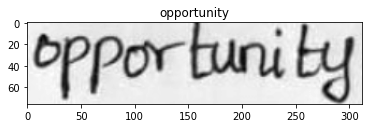

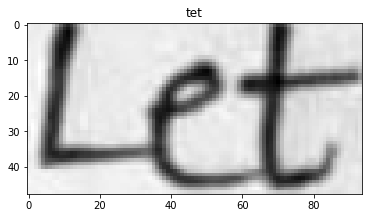

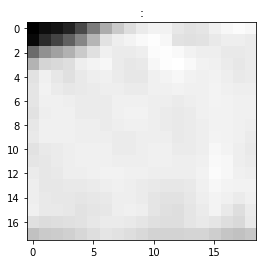

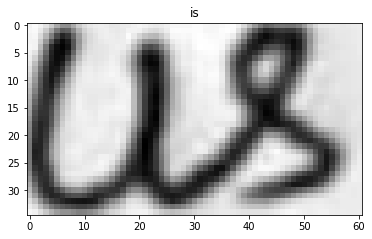

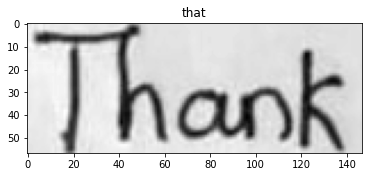

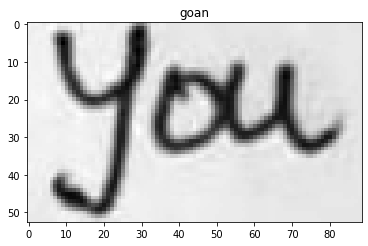

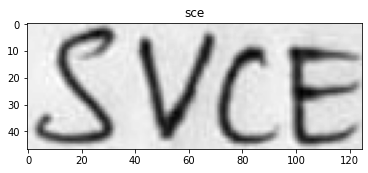

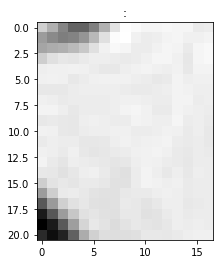

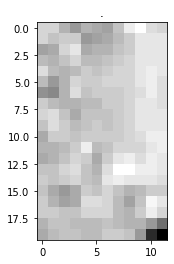

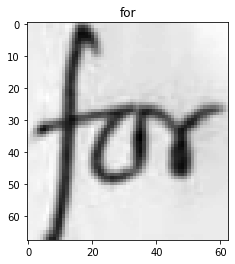

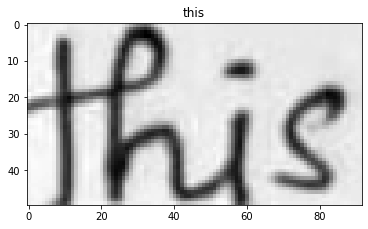

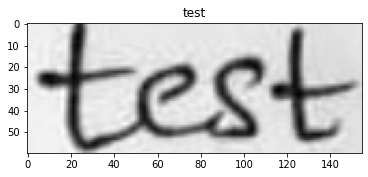

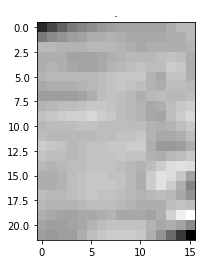

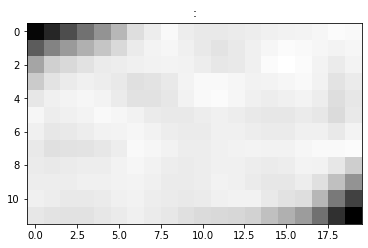

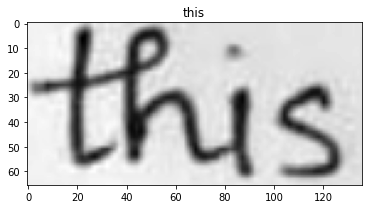

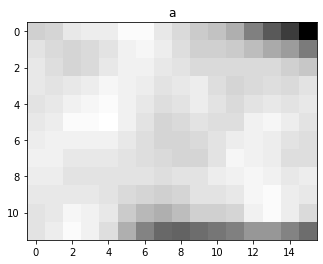

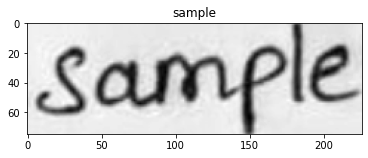

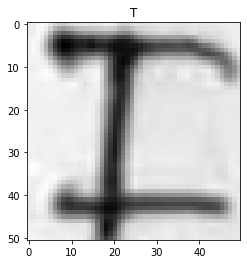

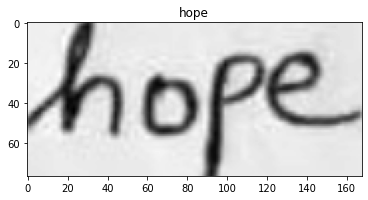

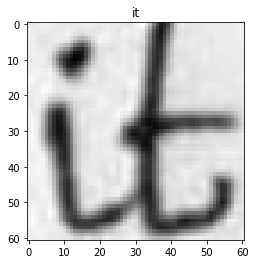

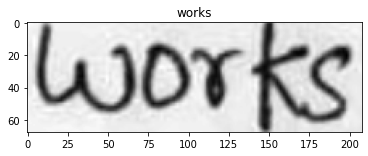

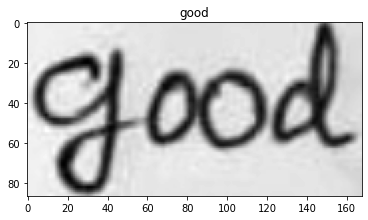

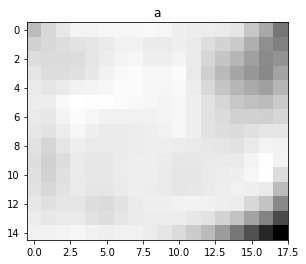

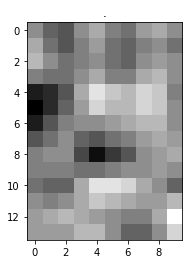

In [ ]:
print('PREDICTED TEST \n\n')
for j,i in enumerate(arr):
  img = cv2.imread('/content/drive/My Drive/to predict words/{}'.format(i), cv2.COLOR_BGR2GRAY)
  
  
  image = mpimg.imread('/content/drive/My Drive/to predict words/{}'.format(i))
  PO=spell.correction(print_words[j]) 
  plt.figure()
  plt.title(PO)
  plt.imshow(image)
  
  

